# **Entrega 3 - Lunar Lander con Q-Learning**

### **1. Bibliotecas**

In [2]:
import sys
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import pygame
from pygame.locals import *
import pickle

### **2. Jugando a mano**

A continuación se puede jugar un episodio del lunar lander. Se controlan los motores con el teclado. Notar que solo se puede realizar una acción a la vez (que es parte del problema), y que en esta implementación, izq toma precedencia sobre derecha, que toma precedencia sobre el motor principal.

In [4]:
# Inicializar pygame (para el control con el teclado) y el ambiente
pygame.init()
env = gym.make('LunarLander-v2', render_mode='human')
env.reset()
pygame.display.set_caption('Lunar Lander')

clock = pygame.time.Clock()
done = False

while not done:
    for event in pygame.event.get():
        if event.type == QUIT:
            done = True
            break

    keys = pygame.key.get_pressed()

    # Map keys to actions
    if keys[K_LEFT]:
        action = 3  # Fire left orientation engine
    elif keys[K_RIGHT]:
        action = 1 # Fire right orientation engine
    elif keys[K_UP]:
        action = 2  # Fire main engine
    else:
        action = 0  # Do nothing

    _, _, terminated, truncated, _ = env.step(action)
    env.render()
    clock.tick(10)

    if terminated or truncated:
        done = True

env.close()
pygame.quit()

### **3. Discretizando el estado**

El estado consiste de posiciones y velocidades en (x,y,theta) y en información de contacto de los pies con la superficie.

Como varios de estos son continuos, tenemos que discretizarlos para aplicar nuestro algoritmo de aprendizaje por refuerzo tabular.

In [3]:
# Cuántos bins queremos por dimensión
# Pueden considerar variar este parámetro
bins_per_dim = 16

#          Estado:
#          (x,            y,            x_vel,        y_vel,        theta,        theta_vel,    pie_izq_en_contacto, pie_derecho_en_contacto)
NUM_BINS = [bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, 2, 2]

env = gym.make('LunarLander-v2')
env.reset()

# Tomamos los rangos del env
OBS_SPACE_HIGH = env.observation_space.high
OBS_SPACE_LOW = env.observation_space.low
OBS_SPACE_LOW[1] = 0 # Para la coordenada y (altura), no podemos ir más abajo que la zona de aterrizaje (que está en el 0, 0)

# Los bins para cada dimensión
bins = [
    np.linspace(OBS_SPACE_LOW[i], OBS_SPACE_HIGH[i], NUM_BINS[i] - 1)
    for i in range(len(NUM_BINS) - 2) # last two are binary
]
# Se recomienda observar los bins para entender su estructura
# print ("Bins: ", bins)

env.close()

def discretize_state(state, bins):
    """Discretize the continuous state into a tuple of discrete indices, taking the closest bin."""
    state_disc = list()
    for i in range(len(state)):
        if i >= len(bins):  # For binary features (leg contacts)
            state_disc.append(int(state[i]))
        else:
            # Encuentra el índice del valor más cercano en los bins
            closest_index = np.argmin(np.abs(bins[i] - state[i]))
            state_disc.append(closest_index)
    return tuple(state_disc)

In [6]:
# Ejemplos
print(discretize_state([0.0, 0.0, 0, 0, 0, 0, 1, 1], bins)) # En la zona de aterrizaje y quieto
print(discretize_state([0, 1.5, 0, 0, 0, 0, 0, 0], bins)) # Comenzando la partida, arriba y en el centro

(7, 0, 7, 7, 7, 7, 1, 1)
(7, 14, 7, 7, 7, 7, 0, 0)


### **4. Agentes y la interacción con el entorno**

Vamos a definir una interfaz para nuestro agente:

In [4]:
class Agente:
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones
            - estado: el estado en el que se encuentra actualmente el agente
            - max_accion: el espacio de acciones posibles
            - explorar: si se debe elegir una acción de forma que explore el espacio de estados, o eligiendo la que mejor recompensa cree que devuelve
        """
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado) -> None:
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó en esta transición
        """
        pass

    def fin_episodio(self) -> None:
        """Actualizar estructuras al final de un episodio"""
        pass

Para un agente aleatorio, la implementación sería:

In [5]:
class AgenteAleatorio(Agente):
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        # Elige una acción al azar
        return random.randrange(max_accion)

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado) -> None:
        # No aprende
        pass

    def fin_episodio(self) -> None:
        # Nada que actualizar
        pass

Luego podemos definir una función para ejecutar un episodio con un agente dado:

In [5]:
def ejecutar_episodio(agente, aprender=True, render=None, max_iteraciones=500):
    entorno = gym.make('LunarLander-v2', render_mode=render).env
    
    iteraciones = 0
    recompensa_total = 0

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset()
    while iteraciones < max_iteraciones and not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        if (aprender):
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa
        
    if (aprender):
        agente.fin_episodio()

    entorno.close()
    return recompensa_total

In [10]:
# Ejecutamos un episodio con el agente aleatorio y modo render 'human', para poder verlo
ejecutar_episodio(AgenteAleatorio(), render = 'human')

-416.2429461738583

Podemos ejecutar este ambiente muchas veces y tomar métricas al respecto

In [6]:
AgenteAleatorio = AgenteAleatorio()
recompensa_episodios = []

exitos = 0
num_episodios = 100
for i in range(num_episodios):
    recompensa = ejecutar_episodio(AgenteAleatorio, render='human')
    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1
    recompensa_episodios += [recompensa]

print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {np.mean(recompensa_episodios)} de recompensa, en promedio")

Tasa de éxito: 0.0. Se obtuvo -195.70000348805894 de recompensa, en promedio


### **5. Programando un agente que aprende**

La tarea a realizar consiste en programar un agente de aprendizaje por refuerzos:

In [6]:
'''
Hiperparametros
  Política de exploración (random, epsilon-greedy)
  epsilon
  Politica de aprendizaje (Aprender en el momento / Aprender al final)
  Cantidad de bins
'''

class AgenteRL(Agente):

    def __init__(self, epsilon=0.1, politica_exploracion='epsilon-greedy', aprender_inmediatamente=True) -> None:
        '''
        Parametros
        ----------
        epsilon: Usado si politica_exploracion=epsilon-greedy / Probabilidad de exploración en cada paso
        politica_exploracion: Función que determinará la acción a tomar en caso de encontrarse explorando. ( random, epsilon-greedy)
        aprender_inmediatamente: Si el agente debe aprender en el momento o al final del episodio haciendo un recorrido "hacia atrás"

        Utiliza una función de aprendizaje Q-Learning no-determinista, mediante la fórmula:
        Q(s, a) = (1 - alfa) * Q(s, a) + alfa * (recompensa + max(Q(s', a')))
        donde alfa=1/cantidad_visitas(s, a)
        '''
        super().__init__()
        self.Q = {}
        self.cantidad_visitas = {}
        
        self.epsilon = epsilon
        self.politica_exploracion = politica_exploracion
        self.aprender_inmediatamente = aprender_inmediatamente

        # En caso de que aprenda al finalizar el episodio, se guardan las acciones tomadas
        self.acciones_tomadas = []

    def elegir_accion(self, estado, max_accion, explorar=True) -> int:
        estado = discretize_state(estado, bins)
        self.max_accion = max_accion

        # La tabla Q y cantidad_visitas se genera a medida que se visitan estados
        if estado not in self.Q:
            self.Q[estado] = {i: 0 for i in range(max_accion)}
            for accion in range(max_accion):
                self.cantidad_visitas[(estado, accion)] = 0     

        if explorar: # Explorar

            match self.politica_exploracion:
                case 'random':
                    return random.randrange(max_accion)
            
                case 'epsilon-greedy':
                    if random.random() < self.epsilon:
                        return random.randrange(max_accion)
                    else:
                        return max(self.Q[estado], key=self.Q[estado].get)

        else: # Explotacion
            return max(self.Q[estado], key=self.Q[estado].get)

    def aprender(self, estado_anterior, estado_actual, accion, recompensa, terminado) -> None:
        estado_anterior = discretize_state(estado_anterior, bins)
        estado_actual   = discretize_state(estado_actual, bins)
        
        # La tabla Q y cantidad_visitas se genera a medida que se visitan estados
        for estado in [estado_anterior, estado_actual]:
            if estado not in self.Q:
                self.Q[estado] = {i: 0 for i in range(self.max_accion)}
                for a in range(4):
                    self.cantidad_visitas[(estado, a)] = 0
            
        self.cantidad_visitas[(estado_anterior, accion)] += 1 

        if (self.aprender_inmediatamente):
            alfa = 1 / self.cantidad_visitas[(estado_anterior, accion)]
            self.Q[estado_anterior][accion] = (1 - alfa) * self.Q[estado_anterior][accion] + alfa * (recompensa + max(self.Q[estado_actual].values()))
        else:
            self.acciones_tomadas.append((estado_anterior, estado_actual, accion, recompensa))     


    def fin_episodio(self) -> None:
        '''
        En caso de que el agente aprenda al final del episodio, se recorre hacia atrás las acciones tomadas durante
        el episodio y se actualizan los valores de Q
        En caso contrario, no se hace nada
        '''
        if (not self.aprender_inmediatamente):
            for i in range(len(self.acciones_tomadas)-1, -1, -1):
                estado_anterior, estado_actual, accion, recompensa = self.acciones_tomadas[i]
                alfa = 1 / self.cantidad_visitas[(estado_anterior, accion)]
                self.Q[estado_anterior][accion] = (1 - alfa) * self.Q[estado_anterior][accion] + alfa * (recompensa + max(self.Q[estado_actual].values()))

            self.acciones_tomadas = []

Y ejecutar con el muchos episodios:

In [17]:
agente = AgenteRL()
exitos = 0
recompensa_episodios = []
num_episodios = 100
for i in range(num_episodios):
    recompensa = ejecutar_episodio(agente)
    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1
    recompensa_episodios += [recompensa]
print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {np.mean(recompensa_episodios)} de recompensa, en promedio")

Tasa de éxito: 0.0. Se obtuvo -144.36276908473633 de recompensa, en promedio


### **6. Parametros utilizados**

#### 6.1 Agente implementado

El agente tiene varios hiperparámetros configurables:

- Política de exploración: Puede ser `random`, eligiendo siempre acciones aleatorias, o `epsilon-greedy`, donde se define una probabilidad (epsilon) para seleccionar una acción aleatoria en lugar de la mejor opción conocida.
- Epsilon: Probabilidad de seleccionar una acción aleatoria en cada paso, utilizada solo cuando la política es epsilon-greedy.
- Momento de actualización de Q: El agente puede aprender en cada paso, o almacenar todas las acciones durante un episodio y actualizar la tabla Q al final del episodio, recorriendo las acciones en orden inverso.
- Cantidad de bins: El espacio de estados, que incluye la posición (x, y), velocidad (vx, vy), ángulo de rotación y velocidad angular, puede discretizarse con una cantidad variable de bins.

Al discretizar el espacio de estados, la recompensa para una tupla (estado, acción) se vuelve no determinista. Por ello, se utiliza un parámetro de tasa de aprendizaje (alpha), calculado en cada paso como 1 / cantidad_visitas(estado, acción).

Dado que el espacio de estados puede alcanzar millones de combinaciones, para evitar un uso excesivo de memoria, tanto la tabla Q como el mapa de visitas se generan dinámicamente a medida que se exploran los estados.


#### 6.2 Política de exploración

A continuación, se experimenta con las dos políticas de exploración implementadas:

- `Random`
- `Epsilon-greedy`, con valores de epsilon 0.1, 0.3, 0.5, 0.7 y 0.9.

Se genera entonces un agente para cada configuración y se lo entrena durante 20.000 episodios. Luego, se comparan los resultados obtenidos con cada uno al utilizar únicamente explotación de las acciones aprendidas durante 1.000 episodios.

In [13]:
num_episodios = 20000

# Prueba con random
agente_random = AgenteRL(politica_exploracion='random')
for i in range(1, num_episodios):
    _ = ejecutar_episodio(agente_random, aprender=True)

print("Finalizado entrenamiento con random")

# Prueba epsilon-greedy
agentes_epsilon = []  # Array para almacenar los agentes epsilon
for epsilon in [0.1, 0.3, 0.5, 0.7, 0.9]:
    agente_epsilon = AgenteRL(politica_exploracion='epsilon-greedy', epsilon=epsilon)
    for i in range(1, num_episodios):
        _ = ejecutar_episodio(agente_epsilon, aprender=True)

    agentes_epsilon.append(agente_epsilon) 

    print(f'Finalizado entrenamiento con epsilon={epsilon}')

Finalizado entrenamiento con random
Finalizado entrenamiento con epsilon=0.1
Finalizado entrenamiento con epsilon=0.3
Finalizado entrenamiento con epsilon=0.5
Finalizado entrenamiento con epsilon=0.7
Finalizado entrenamiento con epsilon=0.9


A continuación, se ejecutan durante 1000 episodios cada agente con explotación, y se compara el porcentaje de éxitos (episodios en los cuales se consiguen más de 200 puntos) y el promedio obtenido durante todos los episodios.

In [17]:
promedios = [] 
exitos = []

recompensa_episodios = []
cant_exitos = 0
for i in range(1000):
    recompensa = ejecutar_episodio(agente_random, aprender=False)
    if (recompensa >= 200):
        cant_exitos += 1
    recompensa_episodios += [recompensa]
promedios.append(np.mean(recompensa_episodios))
exitos.append(cant_exitos/1000)

for agente in agentes_epsilon:
    recompensa_episodios = []
    cant_exitos = 0
    for i in range(1000):
        recompensa = ejecutar_episodio(agente, aprender=False)
        if (recompensa >= 200):
            cant_exitos += 1
        recompensa_episodios += [recompensa]
    promedios.append(np.mean(recompensa_episodios))
    exitos.append(cant_exitos/1000)

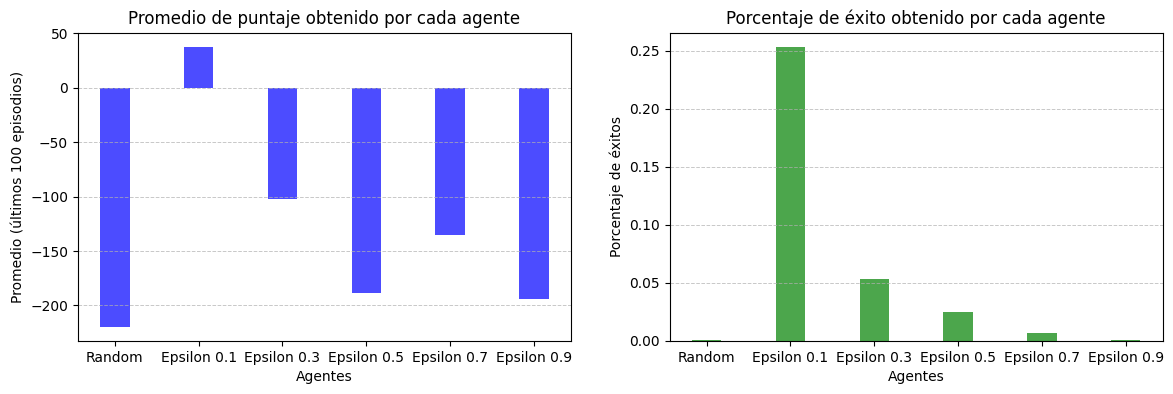

In [27]:
agentes = ['Random', 'Epsilon 0.1', 'Epsilon 0.3', 'Epsilon 0.5', 'Epsilon 0.7', 'Epsilon 0.9']
bar_width = 0.35
indices = np.arange(len(agentes))

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].bar(indices, promedios, bar_width, color='b', alpha=0.7)
axes[0].set_xlabel('Agentes')
axes[0].set_ylabel('Promedio (últimos 100 episodios)')
axes[0].set_title('Promedio de puntaje obtenido por cada agente')
axes[0].set_xticks(indices)
axes[0].set_xticklabels(agentes)
axes[0].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

axes[1].bar(indices, exitos, bar_width, color='g', alpha=0.7)
axes[1].set_xlabel('Agentes')
axes[1].set_ylabel('Porcentaje de éxitos')
axes[1].set_title('Porcentaje de éxito obtenido por cada agente')
axes[1].set_xticks(indices)
axes[1].set_xticklabels(agentes)
axes[1].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.show()



Se observa como el agente que utiliza la política de exploración `epsilon-greedy` con epsilon=0.1 obtiene los mejores resultados por un gran margen, con un promedio de aproximadamente 30 puntos, y un porcentaje de éxito de aproximadamente 25%.

Este valor de epsilon siendo el óptimo dentro del conjunto probado, que le da tanta importancia a la explotación por encima de la exploración, puede deberse al tamaño del espacio de estados. En un entorno con muchas posibilidades, intentar abarcar demasiados estados mediante una exploración intensa puede resultar ineficaz, ya que "el que mucho abarca, poco aprieta". En cambio, un enfoque más conservador que prioriza la explotación de lo aprendido puede conducir a mejores resultados, dado que el agente se concentra en acciones con mayor probabilidad de éxito.

Por lo tanto, en las siguientes secciones, haremos uso de agentes que utilicen la política de exploración `epsilon-greedy` con epsilon=0.1.

#### 6.3 Aprender inmediatamente vs al final

Utilizando los valores de la política de exploración óptima hallada en la parte anterior, se comparan las evoluciones de los promedios de las recompensas al hacer que el agente aprenda al tomar cada acción, o guardando todas las acciones tomadas y sus recompensas, y haciendo una ejecución "hacia atrás", para acelerar el tiempo de entrenamiento.

El promedio se calculará sobre los puntajes obtenidos durante los últimos 100 episodios, de forma que se pueda observar claramente su evolución, y los puntajes obtenidos cuando el agente aún no tenía ningún entrenamiento no afecten los cálculos al medir los resultados del agente luego de cierto número de episodios.

In [ ]:
num_episodios = 40000

agente_epsilon_inmediato = AgenteRL(politica_exploracion='epsilon-greedy', epsilon=0.1, aprender_inmediatamente=True)
recompensa_parcial = []
promedios_recompensas_inmediato = []
for i in range(1, num_episodios):
    recompensa = ejecutar_episodio(agente_epsilon_inmediato, aprender=True, max_iteraciones=500)
    recompensa_parcial.append(recompensa)
    if (i % 100 == 0):
        promedios_recompensas_inmediato.append(np.mean(recompensa_parcial))
        recompensa_parcial = []

agente_epsilon_final = AgenteRL(politica_exploracion='epsilon-greedy', epsilon=0.1, aprender_inmediatamente=False)
recompensa_parcial = []
promedios_recompensas_final = []
for i in range(1, num_episodios):
    recompensa = ejecutar_episodio(agente_epsilon_final, aprender=True, max_iteraciones=500)
    recompensa_parcial.append(recompensa)
    if (i % 100 == 0):
        promedios_recompensas_final.append(np.mean(recompensa_parcial))
        recompensa_parcial = []


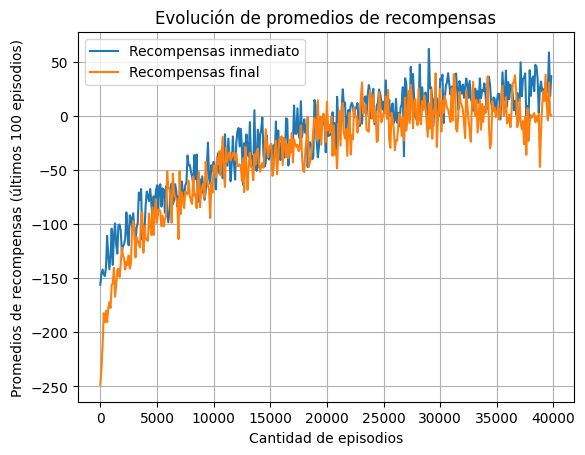

In [12]:
x_values = [i * 100 for i in range(len(promedios_recompensas_inmediato))]

y_values_inmediato = promedios_recompensas_inmediato
y_values_final = promedios_recompensas_final

plt.plot(x_values, y_values_inmediato, label='Recompensas inmediato')
plt.plot(x_values, y_values_final, label='Recompensas final')
plt.title('Evolución de promedios de recompensas')
plt.xlabel('Cantidad de episodios')
plt.ylabel('Promedios de recompensas (últimos 100 episodios)')
plt.legend()
plt.grid()
plt.show()

Al comparar ambas metodologías, se observa como el aprender de forma inmediata da resultados ligeramente superiores a su contraparte. Aun así ambas formas poseen algunas similitudes:
- Crecen de igual manera.
- Ambas alcanzan promedios de puntajes positivos.
- Parecen comenzar a converger luego de alcanzar un promedio de 0 puntos.

Entrenaremos entonces un agente que aprenda de forma inmediata durante 100.000 episodios, para poder ver la evolución de la recompensa promedio.

In [ ]:
num_episodios = 100000

agente_epsilon_inmediato = AgenteRL(politica_exploracion='epsilon-greedy', epsilon=0.1, aprender_inmediatamente=True)
recompensa_parcial = []
promedios_recompensas_inmediato = []
for i in range(1, num_episodios):
    recompensa = ejecutar_episodio(agente_epsilon_inmediato, aprender=True, max_iteraciones=500)
    recompensa_parcial.append(recompensa)
    if (i % 100 == 0):
        promedios_recompensas_inmediato.append(np.mean(recompensa_parcial))
        recompensa_parcial = []

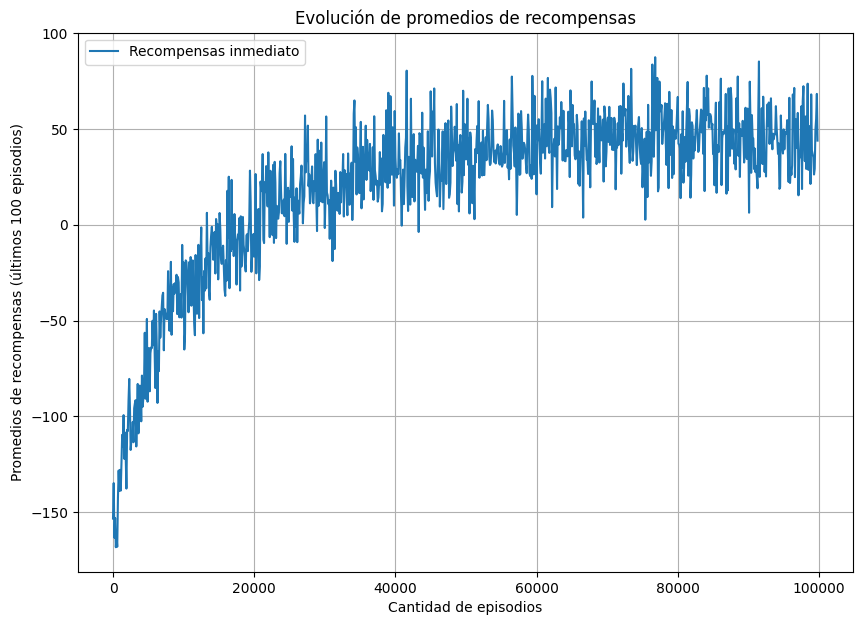

In [8]:
x_values = [i * 100 for i in range(len(promedios_recompensas_inmediato))]
y_values_inmediato = promedios_recompensas_inmediato

plt.figure(figsize=(10, 7)) 
plt.plot(x_values, y_values_inmediato, label='Recompensas inmediato')
plt.title('Evolución de promedios de recompensas')
plt.xlabel('Cantidad de episodios')
plt.ylabel('Promedios de recompensas (últimos 100 episodios)')
plt.legend()
plt.grid()
plt.show()

Se observa como el agente aprende de forma rápida durante los primeros 40.000 episodios aproximadamente, para luego desacelerar una vez obtiene promedios positivos, alrededor de 30 puntos.
La forma caótica de la gráfica (con muchos picos) se debe al hecho de que el agente, aun priorizando la explotación, sigue teniendo probabilidades de tomar elecciones aleatorias, por lo que los puntajes obtenidos durante 100 episodios pueden no ser del todo representativos sobre lo aprendido por el agente.


#### 6.4 Número de bins

El número de bins empleado hasta ahora fue de $n=16$, obtenido mediante prueba y error$^1$, probando diferentes configuraciones.
Este número parece funcionar por dos razones:
- Un número más bajo provocaría que se pierda información detallada como por ejemplo sobre la posición o la velocidad actual, puesto que se está pasando de un espacio continuo a uno discreto. 
- Tomando en cuenta que el orden del espacio de estados se encuentra en los millones, por ejemplo, para $n=20$ el número de estados posibles es $20^6 \times 4 = 256.000.000$, por lo que aumentos pequeños en el número de bins provocan una ampliación muy grande en el número de estados, por lo que el tiempo de entrenamiento necesario para que nuestro agente pueda aprender de forma correcta aumenta de forma exponencial. Para el caso de $n=16$, tenemos $16^6 \times 4 = 67.108.864$

En resumen, $n=16$ es un equilibrio entre la información perdida de cada estado por la discretización, y el tiempo de entrenamiento necesario de nuestro agente.

1: El proceso se dió iniciando con 20 bins, al aumentar la cantidad de bins se encontraron peores resultados, mientras que reduciendo, mejora significativamente hasta llegar a 16. Para $ n\leq 15$, los resultados empeoran.

### **7. Entrenamiento del agente con los mejores parámetros encontrados**

El proceso de entrenamiento del agente se realiza en un millón de episodios (siguiente celda). Esto tomó aproximadamente 6 horas para completarlo, al utilizar un equipo con procesador Intel(R) Core(TM) i5-12400 a 2.50GHz y 32GB de RAM. Para evitar repetir este entrenamiento se persiste el agente guardado y se deja la opción de cargarlo a memoria en esta sección.

#### 7.1 Alternativa 1: Entrenar el agente

In [ ]:
agente_1_millon_episodios = AgenteRL(politica_exploracion='epsilon-greedy', epsilon=0.1, aprender_inmediatamente=True)

num_episodios = 1_000_000
for i in range(1, num_episodios):
    _ = ejecutar_episodio(agente_1_millon_episodios, aprender=True)

#### 7.2 Alternativa 2: Obtener el agente entrenado desde el almacenamiento secundario

In [7]:
with open('agente_1_millon_episodios.pkl', 'rb') as archivo:
    agente_1_millon_episodios = pickle.load(archivo)

### 8. Resultados y análisis

En la siguiente celda se ejecutan 1000 episodios y se calcula el porcentaje de éxito, así como el promedio de recompensas al utilizar el agente entrenado con un millón de episodios.

In [9]:
num_exitos = 0
puntajes=[]

for i in range(1000):
    recompensa = ejecutar_episodio(agente_1_millon_episodios, aprender=False, render=None)
    if recompensa >= 200:
        num_exitos += 1
    puntajes.append(recompensa)

print(f"Porcentaje de exitos: {num_exitos/1000}")
print(f"Promedio de recompensas: {np.mean(puntajes)}")


Porcentaje de exitos: 0.365
Promedio de recompensas: 87.0557486781262


Se observa que el agente obtiene un porcentaje de éxito de 36.5%, y un promedio de recompensas de 87 puntos.

#### **8.1. Casos de éxito y fracaso**

En esta subsección se estudia el comportamiento del agente entrenado con un millón de episodios en los casos de éxito y de fracaso. Se usará la bandera `render='human'` para poder visualizar al agente durante 200 episodios.

En ambos casos se puede concluir lo siguiente: 
- En la mayoría de los casos, la nave se mantiene estable, mantiene el ángulo ($\theta$) controlado. Sin embargo, si se pierde el control el agente no es capaz de retomarlo.

Dentro de los casos de fracaso y qué los generó, se concluye lo siguiente:
- Algunos fracasan debido al terreno, ya que venía en buen camino pero al aterrizar lo hace sobre un "pico" y cuenta como un choque.
- Algunos episodios fracasan porque la nave se queda flotando (aunque si fueran más iteraciones en algunos casos podría haber sido exitoso).
- Logra aterrizar pero debido al terreno en pendiente, este se queda deslizando e intenta corregirse sin éxito.
- La inmensa mayoría de fracasos se debe a que la nave no logra bajar la velocidad a tiempo y las patas no logran amortiguar el aterrizaje, a pesar de que el episodio era prometedor.

Para los casos de éxito:
- La gran mayoría de ellos la nave aterriza entre las banderas. 
- En los casos que empieza moviéndose hacia algún costado, la nave se corrige rápidamente a medida que baja, aterrizando correctamente entre las banderas.
- En pocos casos aterriza cerca de las banderas, pero del lado de afuera. Y aún en menor frecuencia, se dan casos de éxito cuando aterriza lejos.

#### 8.2 Casos particulares
Para profundizar el entendimiento del agente, estudiamos cómo se comporta en algunas situaciones particulares, pero antes de proceder, es necesario entender la semántica de los estados:

Debido a la discretización, los estados de posición y velocidad están comprendidos en el rango $[0, ... , 15]$. Para la velocidad, el valor $7$ indica que no se está moviendo en el eje determinado. Para el eje $x$, a menor valor significa que tiene velocidad hacia la izquierda, mientras que para el eje $y$ la velocidad vertical es negativa. Sucede similar para el ángulo ($\theta$) y la velocidad de rotación ($\omega$).

A continuación se exploran dos ejemplos. 

##### Ejemplo 1: Caída
La caída se da cuando la velocidad vertical de la nave se encuentra en el rango $v_\text{y} \in[0, ..., 6]$. Por lo que es esperable que en gran parte de los casos la acción a tomar sea la de encender el propulsor inferior, amortiguando la caída.

El siguiente bloque cuenta las distintas decisiones que se toman en esta circunstancias en orden de acción (nada, motor derecho, motor inferior, motor izquierdo)

In [15]:
cayendo = []

for estado in list(agente_1_millon_episodios.Q):
    if estado[3] < 7 and (estado[4] == 7 or estado[4] == 6) and (estado[5] == 7 or estado[5] == 6):
        cayendo.append(estado)


estado_acciones = []
for estado in cayendo:
    acciones = list(agente_1_millon_episodios.Q[estado].values())
    estado_acciones.append((estado, np.argmax(acciones)))

cant = [0, 0, 0, 0]

for ea in estado_acciones:
    cant[ea[1]] += 1

print(f"Cantidad de veces que no hace nada: {cant[0]}")
print(f"Cantidad de veces que enciende el motor derecho: {cant[1]}")
print(f"Cantidad de veces que enciende el motor izquierdo: {cant[3]}")
print(f"Cantidad de veces que enciende el motor principal: {cant[2]}")


Cantidad de veces que no hace nada: 577
Cantidad de veces que enciende el motor derecho: 844
Cantidad de veces que enciende el motor izquierdo: 262
Cantidad de veces que enciende el motor principal: 1827


Los resultados muestran que el grueso de las decisiones se distribuyen entre **encender el motor inferior**, amortiguando la caída, y **no hacer nada**. Esto es coherente con lo esperado del agente, sin embargo es interesante observar la cantidad de veces en las que se elige no encender ningún motor. Una posible explicación de esto es que la acción por defecto de un estado inexplorado es la inacción.

#### Ejemplo 2: Rotación en sentido horario.
Otro caso de estudio es el del ángulo de la nave, intuitivamente se espera de un buen agente que, en general, intente corregir su ángulo encendiendo el propulsor que lo impulse para el lado contrario al que está inclinado.

Tomamos el caso de $\theta \in [0, ... , 5]$ (objeto rotado en sentido horario).

Los resultados pueden observarse en en la siguiente celda, en el mismo formato que el caso de estudio anterior:

In [17]:
rotando = []

for estado in list(agente_1_millon_episodios.Q):
    if estado[4] < 5:
        rotando.append(estado)

estado_acciones = []
for estado in cayendo:
    acciones = list(agente_1_millon_episodios.Q[estado].values())

    estado_acciones.append((estado, np.argmax(acciones)))


cant = [0, 0, 0, 0]

for ea in estado_acciones:
    cant[ea[1]] += 1

print(f"Cantidad de veces que no hace nada: {cant[0]}")
print(f"Cantidad de veces que enciende el motor derecho: {cant[1]}")
print(f"Cantidad de veces que enciende el motor izquierdo: {cant[3]}")
print(f"Cantidad de veces que enciende el motor principal: {cant[2]}")

Cantidad de veces que no hace nada: 1759
Cantidad de veces que enciende el motor derecho: 2211
Cantidad de veces que enciende el motor izquierdo: 818
Cantidad de veces que enciende el motor principal: 831


Se observa que la mayoria de las veces se elige o bien **no hacer nada**, o bien **encender el motor derecho**, aportando hacia una rotación en sentido antihorario. Nuevamente, esto es lo esperado del agente.

### **9. Limitantes y posibles mejoras**

- Dado que se trabaja en un espacio continuo, la necesidad de discretizar para que el entrenamiento sea viable limita la cantidad de información con la que nuestro agente trabaja. Esta es una limitante inherente al propio problema a resolver, por lo que no conocemos una manera clara de mitigarlo usando las herramientas vistas en el curso.

- Nuestro agente no es capaz de utilizar la información del suelo para elegir mejores acciones, y no tenemos forma de saber cómo esto afecta en la etapa de aprendizaje. Esto podría mejorarse codificando la información de cómo está construido el suelo en cada episodio, y utilizando esta información como parte del espacio de estados. Es claro que, de aplicar esta mejora, se debe asumir el costo de incrementar el espacio de estados.

- Por último, el limitante más claro es el tiempo dedicado al entrenamiento y el poder de cómputo disponible para el equipo. Puesto que a mayor capacidad de procesamiento, se podrían utilizar un valor más alto en el número de bins utilizado, aumentando la información con la que trabaja el agente. Esto fue visto al reentrenar el agente con un millón de episodios en contraste a cien mil o menos.